In [3]:
import os

import matplotlib.pyplot as plt

from PIL import Image
import torchvision.transforms.functional as TF

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from ortools.linear_solver import pywraplp
from time import gmtime, strftime


NUM_CLASSES = 2
NUM_FEATURES = 100

class VOCDataset(Dataset):
    """Class to store VOC semantic segmentation dataset"""

    def __init__(self, image_dir, label_dir, file_list):

        self.image_dir = image_dir
        self.label_dir = label_dir
        reader = open(file_list, "r")
        self.files = []
        for file in reader:
            self.files.append(file.strip())

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        # 0 stands for background, 1 for foreground
        labels = np.load(os.path.join(self.label_dir, fname+".npy"))
        labels[labels > 0.0] = 1.0
        image = Image.open(os.path.join(self.image_dir, fname+".jpg"), "r")
        sample = (TF.to_tensor(image), torch.LongTensor(labels))

        return sample


class AlexNet(nn.Module):
    """Class defining AlexNet layers used for the convolutional network"""

    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=2, padding=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        return x


class FCNHead(nn.Sequential):
    """Class defining FCN (fully convolutional network) layers"""

    def __init__(self, in_channels, channels):
        inter_channels = in_channels // 4
        layers = [
            nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(inter_channels, channels, 1)
        ]

        super(FCNHead, self).__init__(*layers)


class SimpleSegmentationModel(nn.Module):
    """
    Class defining end-to-end semantic segmentation model.
    It combines AlexNet and FCN layers with interpolation for deconvolution.
    This model is pretrained using cross-entropy loss.
    After pre-training, use the get_repr() function to construct 32x32x100 feature tensors for each image
    """

    def __init__(self, n_feat, n_classes):
        super(SimpleSegmentationModel, self).__init__()
        self.n_feat = n_feat
        self.backbone = AlexNet()
        self.classifier = FCNHead(256, n_feat)
        self.linear = nn.Linear(n_feat, n_classes)

    def forward(self, x):
        repr = self.get_repr(x)
        repr = repr.contiguous().view(-1, self.n_feat)
        out = self.linear(repr)
        return out

    def get_repr(self, x):
        input_shape = x.shape[-2:]
        features = self.backbone(x)
        x = self.classifier(features)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        x = x.permute(0, 2, 3, 1)
        return x



def train_cnn(model, train_batches, num_epochs):
    """
    This function runs a training loop for the FCN semantic segmentation model
    """
    print("Training CNN...")
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1, 4]).cuda())
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for i, batch in enumerate(train_batches):
            optimizer.zero_grad()
            images, labels = batch
            images = images.cuda()
            output = model(images)
            output = output.cuda()
            labels = labels.cuda()
            labels = labels.contiguous().view(-1, 1).squeeze()
            loss = criterion(output, labels)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        print("Training loss after epoch {}: {}".format(epoch, total_loss/len(train_batches)))


def test_cnn(model, test_batches):
    """
        This function evaluates the FCN semantic segmentation model on the test set
    """
    with torch.no_grad():
        model.eval()
        correct = 0.0
        total = 0.0
        class_gold = [0.0] * NUM_CLASSES
        class_pred = [0.0] * NUM_CLASSES
        class_correct = [0.0] * NUM_CLASSES
        for i, batch in enumerate(test_batches):
            images, labels = batch
            images = images.cuda()
            output = model(images).cuda()
            labels = labels.cuda()
            _, output = torch.max(output, axis=1)
            visualize_grayscale_image(output.view(32, 32).cpu().numpy(), i)
            output = output.squeeze().cpu().numpy()
            labels = labels.contiguous().view(-1, 1).squeeze().cpu().numpy()
            cur_class_pred = np.unique(output, return_counts=True)
            for key, val in zip(cur_class_pred[0], cur_class_pred[1]):
                class_pred[key] += val
            cur_class_gold = np.unique(labels, return_counts=True)
            for key, val in zip(cur_class_gold[0], cur_class_gold[1]):
                class_gold[key] += val
            cur_correct = (output == labels).tolist()
            for j, val in enumerate(cur_correct):
                if val:
                    class_correct[labels[j]] += 1
            correct += np.sum(cur_correct)
            total += len(labels)
        class_iou = [x/(y+z-x) for x, y, z in zip(class_correct, class_gold, class_pred)]
        mean_iou = sum(class_iou) / len(class_correct)
        print("CNN Mean IOU: {}".format(mean_iou))
        print("CNN Pixel Accuracy: {}".format(correct / total))



def visualize_grayscale_image(image, file=None, save=False):
    plt.imshow(image, cmap="gray")
    # Uncomment this to visualize image
    # plt.show()
    # Uncomment this to save image
    # plt.savefig(str(file)+".png")
    if save==True:
        plt.savefig(strftime("%Y-%m-%d_%H:%M", gmtime())+".png")

Training CNN...
Training loss after epoch 0: 0.6340523127317429
Training loss after epoch 1: 0.631809357970953
Training loss after epoch 2: 0.6295247563123703
Training loss after epoch 3: 0.6290496337711811
Training loss after epoch 4: 0.6285039240717888
CNN Mean IOU: 0.43130065201457946
CNN Pixel Accuracy: 0.7223984375
CNN Mean IOU: 0.43180180157332526
CNN Pixel Accuracy: 0.7198036154588336


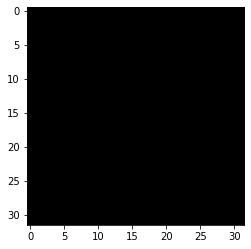

In [4]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Uncomment following lines after providing appropriate paths
train_dataset = VOCDataset('data/DownsampledImages', 'data/DownsampledLabels', 'data/train.txt')
test_dataset = VOCDataset('data/DownsampledImages', 'data/DownsampledLabels', 'data/test.txt')

train_batches = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=1, shuffle=True)

cnn = SimpleSegmentationModel(NUM_FEATURES, NUM_CLASSES).cuda()
train_cnn(cnn, train_batches, 5)
test_cnn(cnn, train_batches)
test_cnn(cnn, test_batches)

# TODO: Instantiate a linear SVM and call train/ test functions
# TODO: Instantiate a structured SVM and call train/ test functions


In [8]:
class LinearSVM(nn.Module):

    def __init__(self, n_feat, n_classes):
        super(LinearSVM, self).__init__()
        self.n_feat = n_feat
        self.n_classes = n_classes
        self.w = nn.Parameter(torch.zeros(n_classes, n_feat), requires_grad=True)
        self.b = nn.Parameter(torch.zeros(n_classes).unsqueeze(0), requires_grad=True)
        # TODO: Define weights for linear SVM

    def forward(self, x):
        # TODO: Define forward function for linear SVM
        x = x.view(-1, x.size(-1))
        return x.matmul(self.w.t()) + self.b
    
class MyHingeLoss(nn.Module):

    def __init__(self):
        super(MyHingeLoss, self).__init__()
        self.relu = nn.ReLU()

    def forward(self, output, target):
        n = target.shape[0]
        target_new = torch.zeros((n,2),dtype=torch.long).cuda()
        for i in range(n):
            target_new[i,target[i]] = 1
        all_ones = torch.ones_like(target_new)
        labels = 2 * target_new - all_ones
        losses = all_ones - torch.mul(output, labels)

        return torch.norm(self.relu(losses))
    
#     def forward(self, output, target):
#         all_ones = torch.ones_like(target)
#         labels = target
#         losses = all_ones - torch.mul(output, labels)

#         return torch.norm(self.relu(losses))



In [9]:
def label_2d(target):
    n = target.shape[0]
    target_new = torch.zeros((n,2),dtype=torch.long).cuda()
    for i in range(n):
        target_new[i,target[i]] = 1
    return target_new

def train_linear_svm(cnn_model, svm_model, train_batches, test_batches, num_epochs):
    # TODO: Write a training loop for the linear SVM
    # Keep in mind that the CNN model is needed to compute features, but it should not be finetuned
    
    print("Training Linear SVM...")
    criterion = MyHingeLoss()
    # criterion = nn.MultiLabelMarginLoss()
    optimizer = optim.Adam(svm_model.parameters(), lr=0.0001)
    for epoch in range(num_epochs):
        total_loss = 0.0
        for i, batch in enumerate(train_batches):
            optimizer.zero_grad()
            images, labels = batch
            images = images.cuda()
            labels = labels.cuda()
            output = svm_model(cnn_model.get_repr(images)).squeeze()
            labels = labels.contiguous().view(-1, 1).squeeze()
            # labels = labels.contiguous().view(-1, 1).repeat((1,2))
            loss = criterion(output, labels)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        print("Training loss after epoch {}: {}".format(epoch, total_loss/len(train_batches)))
        test_linear_svm(cnn_model, svm_model, test_batches)
    return


def test_linear_svm(cnn_model, svm_model, test_batches):
    criterion = MyHingeLoss()
    # criterion = nn.MultiLabelMarginLoss()
    # TODO: Write a testing function for the linear SVM
    with torch.no_grad():
        total_loss = 0.0
        correct = 0.0
        total = 0.0
        class_gold = [0.0] * NUM_CLASSES
        class_pred = [0.0] * NUM_CLASSES
        class_correct = [0.0] * NUM_CLASSES
        for i, batch in enumerate(test_batches):
            images, labels = batch
            images = images.cuda()
            labels = labels.cuda()
            output = svm_model(cnn_model.get_repr(images))
            labels = labels.contiguous().view(-1, 1).squeeze()
            loss = criterion(output, labels)
            total_loss += loss.item()
            _, output = torch.max(output, axis=1)
            visualize_grayscale_image(output.view(32, 32).cpu().numpy(), i)
            output = output.squeeze().cpu().numpy().astype(int)
            labels = labels.contiguous().view(-1, 1).squeeze().cpu().numpy()
            cur_class_pred = np.unique(output, return_counts=True)
            for key, val in zip(cur_class_pred[0], cur_class_pred[1]):
                class_pred[key] += val
            cur_class_gold = np.unique(labels, return_counts=True)
            for key, val in zip(cur_class_gold[0], cur_class_gold[1]):
                class_gold[key] += val
            cur_correct = (output == labels).tolist()
            for j, val in enumerate(cur_correct):
                if val:
                    class_correct[labels[j]] += 1
            correct += np.sum(cur_correct)
            total += len(labels)
        print("Testing loss after epoch: {}".format(total_loss/len(test_batches)))
        class_iou = [x/(y+z-x) for x, y, z in zip(class_correct, class_gold, class_pred)]
        mean_iou = sum(class_iou) / len(class_correct)
        print("LinearSVM Mean IOU: {}".format(mean_iou))
        print("LinearSVM Pixel Accuracy: {}".format(correct / total))
        print()
    return


Training Linear SVM...
Training loss after epoch 0: 38.42778907775879
Testing loss after epoch: 35.25559211881451
LinearSVM Mean IOU: 0.40063937205188677
LinearSVM Pixel Accuracy: 0.8012787441037735

Training loss after epoch 1: 34.44132444190979
Testing loss after epoch: 34.282492273667664
LinearSVM Mean IOU: 0.40063937205188677
LinearSVM Pixel Accuracy: 0.8012787441037735

Training loss after epoch 2: 33.880603281497955
Testing loss after epoch: 33.89866800332764
LinearSVM Mean IOU: 0.40063937205188677
LinearSVM Pixel Accuracy: 0.8012787441037735

Testing loss after epoch: 33.7090067076683
LinearSVM Mean IOU: 0.39865185546875
LinearSVM Pixel Accuracy: 0.7973037109375

Testing loss after epoch: 33.89866800332764
LinearSVM Mean IOU: 0.40063937205188677
LinearSVM Pixel Accuracy: 0.8012787441037735



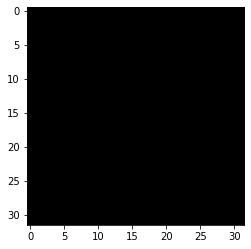

In [13]:
svm = LinearSVM(NUM_FEATURES, NUM_CLASSES).cuda()
# svm = LinearSVM(NUM_FEATURES, 1).cuda()

train_linear_svm(cnn, svm, train_batches, test_batches, 3)
test_linear_svm(cnn, svm, train_batches)
test_linear_svm(cnn, svm, test_batches)

In [7]:
def create_data_model(var_pot, edge_pot, target):
    """Stores the data for the problem."""
    assert var_pot.shape[0]==target.shape[0]
    data = {}
    n = 32
    y_coef = []
    x_coef = []
    for i in range(edge_pot.shape[0]):
        y_coef.append(int(var_pot.shape[0] * (edge_pot[i][0] - edge_pot[i][1])))
        
    for i in range(var_pot.shape[0]):
        x_coef.append(int(var_pot.shape[0] * (var_pot[i][0] - var_pot[i][1]) + (2 * target[i] - 1)))
    data['obj_coeffs'] = x_coef + y_coef
    data['num_vars'] = var_pot.shape[0] + edge_pot.shape[0]
    
    
    data['constraint_coeffs'] = []

    idx = 0
    for i in range(0,n-1):
        for j in range(0,n-1):
            cons1 = [0] * (var_pot.shape[0] + edge_pot.shape[0])
            cons1[i*n+j] = -1
            cons1[idx+var_pot.shape[0]] = 1
            cons2 = [0] * (var_pot.shape[0] + edge_pot.shape[0])
            cons2[i*n+j+1] = -1
            cons2[idx+var_pot.shape[0]] = 1
            data['constraint_coeffs'].append(cons1)
            data['constraint_coeffs'].append(cons2)
            idx = idx + 1
            
            cons1 = [0] * (var_pot.shape[0] + edge_pot.shape[0])
            cons1[i*n+j] = -1
            cons1[idx+var_pot.shape[0]] = 1
            cons2 = [0] * (var_pot.shape[0] + edge_pot.shape[0])
            cons2[i*n+j+n] = -1
            cons2[idx+var_pot.shape[0]] = 1
            data['constraint_coeffs'].append(cons1)
            data['constraint_coeffs'].append(cons2)
            idx = idx + 1

        cons1 = [0] * (var_pot.shape[0] + edge_pot.shape[0])
        cons1[i*n+n-1] = -1
        cons1[idx+var_pot.shape[0]] = 1
        cons2 = [0] * (var_pot.shape[0] + edge_pot.shape[0])
        cons2[i*n+n+n-1] = -1
        cons2[idx+var_pot.shape[0]] = 1
        data['constraint_coeffs'].append(cons1)
        data['constraint_coeffs'].append(cons2)
        idx = idx + 1

    for j in range(0,n-1):
        cons1 = [0] * (var_pot.shape[0] + edge_pot.shape[0])
        cons1[(n-1)*n+j] = -1
        cons1[idx+var_pot.shape[0]] = 1
        cons2 = [0] * (var_pot.shape[0] + edge_pot.shape[0])
        cons2[(n-1)*n+j+1] = -1
        cons2[idx+var_pot.shape[0]] = 1
        data['constraint_coeffs'].append(cons1)
        data['constraint_coeffs'].append(cons2)
        idx = idx + 1


    assert idx == 2*(n-1)*n
    
    data['bounds'] = [0] * 2 * edge_pot.shape[0]
    
    assert len(data['bounds'])==len(data['constraint_coeffs'])
    data['num_constraints'] = len(data['bounds'])
    return data


def MAP_infer(data):
    
    solver = pywraplp.Solver('ILP', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    infinity = solver.infinity()
    x = {}
    for j in range(data['num_vars']):
        x[j] = solver.IntVar(0, 1, 'x[%i]' % j)
    # print('Number of variables =', solver.NumVariables())

    for i in range(data['num_constraints']):
        constraint = solver.RowConstraint(0, data['bounds'][i], '')
    for j in range(data['num_vars']):
        constraint.SetCoefficient(x[j], data['constraint_coeffs'][i][j])
    # print('Number of constraints =', solver.NumConstraints())
    
    # In Python, you can also set the constraints as follows.
    # for i in range(data['num_constraints']):
    #  constraint_expr = \
    # [data['constraint_coeffs'][i][j] * x[j] for j in range(data['num_vars'])]
    #  solver.Add(sum(constraint_expr) <= data['bounds'][i])

    objective = solver.Objective()
    for j in range(data['num_vars']):
        objective.SetCoefficient(x[j], data['obj_coeffs'][j])
    objective.SetMaximization()
    # In Python, you can also set the objective as follows.
    # obj_expr = [data['obj_coeffs'][j] * x[j] for j in range(data['num_vars'])]
    # solver.Maximize(solver.Sum(obj_expr))

    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        result = []
        # print('Objective value =', solver.Objective().Value())
        for j in range(data['num_vars']):
            result.append(x[j].solution_value())
            # print(x[j].name(), ' = ', x[j].solution_value())
        #print()
        #print('Problem solved in %f milliseconds' % solver.wall_time())
        #print('Problem solved in %d iterations' % solver.iterations())
        #print('Problem solved in %d branch-and-bound nodes' % solver.nodes())
        return result
    else:
        print('The problem does not have an optimal solution.')
        return 0
    
    
def make_y(x):
        n = x.size(1)
        dim = x.size(-1)
        x = x.view(-1, x.size(-1))
        y = torch.zeros((2*(n-1)*n ,2*dim))
        y_dict = dict()
        
        idx = 0
        for i in range(0,n-1):
            for j in range(0,n-1):
                y_dict[(idx,(i*n+j,i*n+j+1))] = torch.cat([x[i*n+j],x[i*n+j+1]])
                idx = idx + 1
                y_dict[(idx,(i*n+j,i*n+j+n))] = torch.cat([x[i*n+j],x[i*n+j+n]])
                idx = idx + 1
        
            y_dict[(idx,(i*n+n-1,i*n+n+n-1))] = torch.cat([x[i*n+n-1],x[i*n+n+n-1]])
            idx = idx + 1
        
        for j in range(0,n-1):
            y_dict[(idx,((n-1)*n+j,(n-1)*n+j+1))] = torch.cat([x[(n-1)*n+j],x[(n-1)*n+j+1]])
            idx = idx + 1
        
        assert idx == 2*(n-1)*n
        for key in y_dict.keys():
            y[key[0],:] = y_dict[key]
        
        return y, y_dict
    
    
def make_y_label(x):
        n = x.size(1)
        dim = x.size(-1)
        assert dim==2
        x = x.view(-1, x.size(-1))
        x = x[:,0]
        y = torch.zeros((2*(n-1)*n ,dim))
        y_dict = dict()
        
        idx = 0
        for i in range(0,n-1):
            for j in range(0,n-1):
                y_dict[(idx,(i*n+j,i*n+j+1))] = int(x[i*n+j]==x[i*n+j+1])
                idx = idx + 1
                y_dict[(idx,(i*n+j,i*n+j+n))] = int(x[i*n+j]==x[i*n+j+n])
                idx = idx + 1
        
            y_dict[(idx,(i*n+n-1,i*n+n+n-1))] = int(x[i*n+n-1]==x[i*n+n+n-1])
            idx = idx + 1
        
        for j in range(0,n-1):
            y_dict[(idx,((n-1)*n+j,(n-1)*n+j+1))] = int(x[(n-1)*n+j]==x[(n-1)*n+j+1])
            idx = idx + 1
        
        assert idx == 2*(n-1)*n
        for key in y_dict.keys():
            y[key[0],y_dict[key]] = 1
        
        return y, y_dict

class StructSVM(nn.Module):

    def __init__(self, n_feat, n_classes):
        super(StructSVM, self).__init__()
        self.n_feat = n_feat
        self.n_classes = n_classes
        self.w_var = nn.Parameter(torch.ones(n_classes, n_feat), requires_grad=True)
        self.w_edge = nn.Parameter(torch.ones(n_classes, 2*n_feat), requires_grad=True)
        # TODO: Define weights for structured SVM
       

    def forward(self, x, target):
        # TODO: Define forward function for structured SVM
        y, _ = make_y(x)
        y = y.cuda()
        x = x.view(-1, x.size(-1))
        var_pot = x.matmul(self.w_var.t())
        edge_pot = y.matmul(self.w_edge.t())
        data = create_data_model(torch.clone(var_pot).cpu().detach().numpy().squeeze(), 
                                 torch.clone(edge_pot).cpu().detach().numpy().squeeze(), 
                                 torch.clone(target).cpu().detach().numpy().squeeze())
        result = MAP_infer(data)
        x_out = torch.zeros((var_pot.size(0),2))
        y_out = torch.zeros((edge_pot.size(0),2))
        for i in range(var_pot.size(0)):
            x_out[i,0] = result[i]
            x_out[i,1] = 1 - result[i]
        for i in range(edge_pot.size(0)):
            y_out[i, 0] = result[i + var_pot.size(0)]
            y_out[i, 1] = 1 - result[i + var_pot.size(0)]
        return x_out.cuda(), y_out.cuda(), var_pot.cuda().squeeze(), edge_pot.cuda().squeeze()
    


class MyStructedHingeLoss(nn.Module):

    def __init__(self):
        super(MyStructedHingeLoss, self).__init__()
        self.relu = nn.ReLU()
        

    
    def S_func(self, x, y, var_pot, edge_pot):
        
        sum_x_out = torch.sum(var_pot*x)
        sum_y_out = torch.sum(edge_pot*y)
        
        return sum_x_out + sum_y_out
    
    def x_loss(self, x, target_x):
        assert x.shape[0]==target_x.shape[0]
        x0 = x[:,0]
        xt0 = target_x[:,0]
        return 1 - torch.sum(x0==xt0)/x.shape[0]
    
    def forward(self, x_out, y_out, var_pot, edge_pot, target):
        S_output = self.S_func(x_out, y_out, var_pot, edge_pot)
        target_x = torch.zeros((target.size(0),2))
        for i in range(target.size(0)):
            target_x[i, target[i]] = 1
        target_y, _ = make_y_label(target_x.reshape(1,32,32,-1))
        target_x = target_x.cuda()
        target_y = target_y.cuda()
        S_target = self.S_func(target_x, target_y, var_pot, edge_pot)
        loss_x = self.x_loss(x_out, target_x)
        losses = S_output + loss_x - S_target
        return torch.sum(self.relu(losses))

def train_struct_svm(cnn_model, svm_model, train_batches, test_batches, num_epochs):
    # TODO: Write a training loop for the structured SVM
    # Keep in mind that the CNN model is needed to compute features, but it should not be finetuned
    print("Training Struct SVM...")
    criterion = MyStructedHingeLoss()
    optimizer = optim.Adam(svm_model.parameters(), lr=0.0001) 
    for epoch in range(num_epochs):
        total_loss = 0.0
        for i, batch in enumerate(train_batches):
            optimizer.zero_grad()
            images, labels = batch
            images = images.cuda()
            labels = labels.cuda()
            labels = labels.contiguous().view(-1, 1).squeeze()
            x_out, y_out, var_pot, edge_pot = svm_model(cnn_model.get_repr(images), labels)
            loss = criterion(x_out, y_out, var_pot, edge_pot, labels)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        print("Training loss after epoch {}: {}".format(epoch, total_loss/len(train_batches)))
        test_struct_svm(cnn_model, svm_model, test_batches)
    return


def test_struct_svm(cnn_model, svm_model, test_batches):
    # TODO: Write a testing function for the structured SVM
    criterion = MyStructedHingeLoss()
    with torch.no_grad():
        correct = 0.0
        total = 0.0
        class_gold = [0.0] * NUM_CLASSES
        class_pred = [0.0] * NUM_CLASSES
        class_correct = [0.0] * NUM_CLASSES
        total_loss = 0.0
        for i, batch in enumerate(test_batches):
            images, labels = batch
            images = images.cuda()
            labels = labels.cuda()
            labels = labels.contiguous().view(-1, 1).squeeze()
            x_out, y_out, var_pot, edge_pot = svm_model(cnn_model.get_repr(images), labels)
            loss = criterion(x_out, y_out, var_pot, edge_pot, labels)
            total_loss += loss.item()        
            _, output = torch.max(x_out, axis=1)
            visualize_grayscale_image(output.view(32, 32).cpu().numpy(), i)
            output = output.squeeze().cpu().numpy().astype(int)
            labels = labels.contiguous().view(-1, 1).squeeze().cpu().numpy()
            cur_class_pred = np.unique(output, return_counts=True)
            for key, val in zip(cur_class_pred[0], cur_class_pred[1]):
                class_pred[key] += val
            cur_class_gold = np.unique(labels, return_counts=True)
            for key, val in zip(cur_class_gold[0], cur_class_gold[1]):
                class_gold[key] += val
            cur_correct = (output == labels).tolist()
            for j, val in enumerate(cur_correct):
                if val:
                    class_correct[labels[j]] += 1
            correct += np.sum(cur_correct)
            total += len(labels)
        
        print("Testing loss after epoch: {}".format(total_loss/len(test_batches)))
        class_iou = [x/(y+z-x) for x, y, z in zip(class_correct, class_gold, class_pred)]
        mean_iou = sum(class_iou) / len(class_correct)
        print("StructSVM Mean IOU: {}".format(mean_iou))
        print("StructSVM Pixel Accuracy: {}".format(correct / total))
        print()
    return


In [11]:
svm = StructSVM(NUM_FEATURES, NUM_CLASSES).cuda()

train_struct_svm(cnn, svm, train_batches, test_batches, 5)
test_struct_svm(cnn, svm, train_batches)
test_struct_svm(cnn, svm, test_batches)

Training Struct SVM...
Training loss after epoch 0: 1.59883642578125
Testing loss after epoch: 1.195144993567753
StructSVM Mean IOU: 0.25020651965686713
StructSVM Pixel Accuracy: 0.4993199238850772

Training loss after epoch 1: 1.95348828125
Testing loss after epoch: 2.7242366731882504
StructSVM Mean IOU: 0.3996097514378091
StructSVM Pixel Accuracy: 0.6681865083619211

Training loss after epoch 2: 1.6813544921875
Testing loss after epoch: 8.386810878537736
StructSVM Mean IOU: 0.30548136173024787
StructSVM Pixel Accuracy: 0.6107619532590052

Training loss after epoch 3: 1.6673408203125
Testing loss after epoch: 1.3474016402229845
StructSVM Mean IOU: 0.19309700338238556
StructSVM Pixel Accuracy: 0.3333478505574614



KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fa5f99533a0> (for post_execute):


KeyboardInterrupt: 

Training Struct SVM...
Training loss after epoch 0: 1.8219443359375
Testing loss after epoch: 0.7812089609240995
StructSVM Mean IOU: 0.2886221194510217
StructSVM Pixel Accuracy: 0.5771434123070326

Training loss after epoch 1: 1.7334931640625
Testing loss after epoch: 1.6731078473413379
StructSVM Mean IOU: 0.2808926425588986
StructSVM Pixel Accuracy: 0.5616155660377359

Training loss after epoch 2: 1.5113525390625
Testing loss after epoch: 1.5924660631968268
StructSVM Mean IOU: 0.3811725868805567
StructSVM Pixel Accuracy: 0.7623385237993139

Training loss after epoch 3: 1.59384716796875
Testing loss after epoch: 1.5415809592088336
StructSVM Mean IOU: 0.32008887891295024
StructSVM Pixel Accuracy: 0.6401777578259005

Training loss after epoch 4: 1.8127265625
Testing loss after epoch: 1.8644923215051459
StructSVM Mean IOU: 0.39419012348011595
StructSVM Pixel Accuracy: 0.7880557863421955

Testing loss after epoch: 1.8161240234375
StructSVM Mean IOU: 0.39179452303475293
StructSVM Pixel Accu

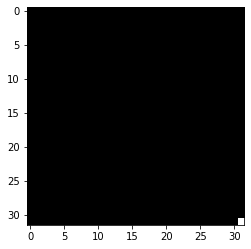

In [9]:
svm = StructSVM(NUM_FEATURES, NUM_CLASSES).cuda()

train_struct_svm(cnn, svm, train_batches, test_batches, 5)
test_struct_svm(cnn, svm, train_batches)
test_struct_svm(cnn, svm, test_batches)

Training Struct SVM...
Training loss after epoch 0: 1.80068701171875
Testing loss after epoch: 1.2287844728237565
StructSVM Mean IOU: 0.37548324870972616
StructSVM Pixel Accuracy: 0.7508593079974271

Training loss after epoch 1: 1.55786865234375
Testing loss after epoch: 1.2760581381325042
StructSVM Mean IOU: 0.22243471134694276
StructSVM Pixel Accuracy: 0.44263407214837047

Training loss after epoch 2: 1.7956650390625
Testing loss after epoch: 1.3600324627465694
StructSVM Mean IOU: 0.36345467146804006
StructSVM Pixel Accuracy: 0.7265976763507719

Training loss after epoch 3: 1.8317763671875
Testing loss after epoch: 1.7321019377144082
StructSVM Mean IOU: 0.3088849972244766
StructSVM Pixel Accuracy: 0.6175643894725558

Training loss after epoch 4: 1.79480078125
Testing loss after epoch: 0.8316577106560892
StructSVM Mean IOU: 0.33391710300817223
StructSVM Pixel Accuracy: 0.6678297196612349

Testing loss after epoch: 0.8120087890625
StructSVM Mean IOU: 0.3275340674594989
StructSVM Pixel 

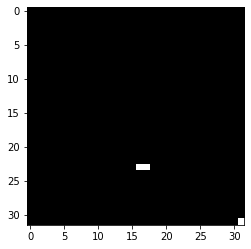

In [10]:
svm = StructSVM(NUM_FEATURES, NUM_CLASSES).cuda()

train_struct_svm(cnn, svm, train_batches, test_batches, 5)
test_struct_svm(cnn, svm, train_batches)
test_struct_svm(cnn, svm, test_batches)